In [ ]:
#задача - обучить CGAN на датасете MNIST.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, Embedding, Flatten, multiply, Reshape, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm_notebook
from tensorflow.keras.optimizers import Adam

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_shape = (X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)

(60000, 28, 28)


In [ ]:
y_train.shape

(60000,)

In [ ]:
optimizer = Adam(0.0002, 0.5)

In [ ]:
#функция для создания генератора
#на вход генератору подаём шум и лейбл (всего 10 классов), на выходе получаем сгенерированное изображение

def get_generator():
    model = Sequential()
    model.add(Dense(units = 256, input_dim = 100))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    
    model.add(Dense(units = 512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    
    model.add(Dense(units = 1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    
    model.add(Dense(np.prod(image_shape), activation = 'tanh'))
    model.add(Reshape(image_shape))
    
    model.summary()
    
    noise = Input(shape = (100, ))
    label = Input(shape = (1, ), dtype = 'int32')
    
    label_embedding = Flatten()(Embedding(10, 100)(label))
        
    model_input = multiply([noise, label_embedding])
    image = model(model_input)
    
    return Model([noise, label], image)

In [ ]:
#функция для создания дискриминатора
#на вход подаём реальное изображение с реальным лейблом

def create_discriminator():
    model = Sequential()
    model.add(Dense(units = 1024, input_dim = np.prod(image_shape)))
    model.add(LeakyReLU(0.2))
        
    model.add(Dense(units = 512))
    model.add(LeakyReLU(0.2))
       
    model.add(Dense(units = 256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    model.summary()
    
    image = Input(shape = image_shape)
    label = Input(shape = (1, ), dtype = 'int32')
    
    label_embedding = Flatten()(Embedding(10, np.prod(image_shape))(label))
    flat_image = Flatten()(image)
    
    model_input = multiply([flat_image, label_embedding])
    
    validity = model(model_input)
    
    
    return Model([image, label], validity)

In [ ]:
#создаём GAN

generator = get_generator()

noise = Input(shape = (100, ))
label = Input(shape = (1, ))
image = generator([noise, label])

discriminator = create_discriminator()
discriminator.compile(loss = ['binary_crossentropy'], optimizer = optimizer, metrics = ['accuracy'])
discriminator.trainable = False

#дискриминатор принимает на вход сгенерированное изображение и определяет, настоящее оно или фейковое, а также лейбл
valid = discriminator([image, label])

gan = Model([noise, label], valid)
gan.compile(loss = ['binary_crossentropy'], optimizer = optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
__________

In [ ]:
#функция для визуализации

def sample_images(epoch):
    rows, cols = 2, 5
    noise = np.random.normal(0, 1, (rows * cols, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_images = generator.predict([noise, sampled_labels])

    fig, axs = plt.subplots(rows, cols)
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap = 'gray')
            axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i, j].axis('off')
            cnt += 1

epochs = 51
batch_size = 32
batch_count = X_train.shape[0] / batch_size

In [ ]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis = 3)
y_train = y_train.reshape(-1, 1)

In [ ]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20



Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40



Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50



Epoch 51


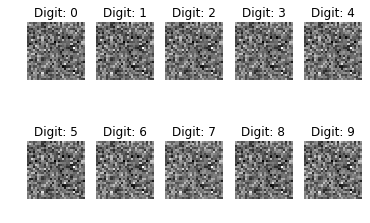

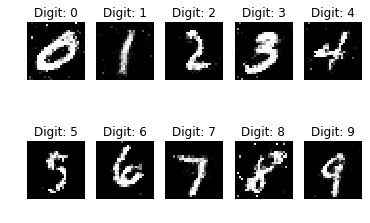

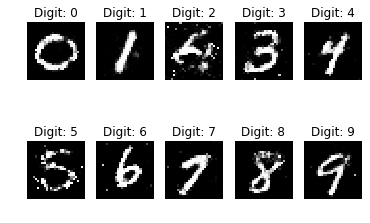

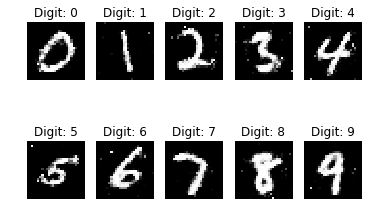

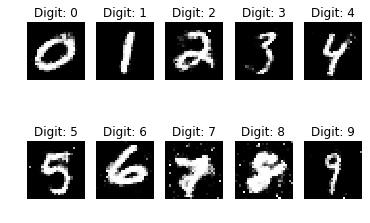

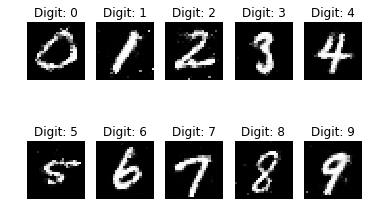

In [ ]:
for e in range(1, epochs + 1):
    print("Epoch %d" %e)
    for _ in tqdm_notebook(range(int(batch_count))):
      
        #выбираем изображения из трейна случайным образом
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        images, labels = X_train[idx], y_train[idx]      
             
        noise = np.random.normal(0, 1, [batch_size, 100])
            
        generated_images = generator.predict([noise, labels])
            
        discriminator.train_on_batch([images, labels], valid)
        discriminator.train_on_batch([generated_images, labels], fake)
          
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)  
        
        gan.train_on_batch([noise, sampled_labels], valid)
             
        if e == 1 or e % 10 == 0:
          if _ % batch_count == 0:
            sample_images(e)